In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries 

import time
import numpy as np
import pandas as pd
import os
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import json
import csv
import seaborn as sns
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from collections import Counter

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Lambda
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#load movie dataset
movie_meta = pd.read_csv("/content/drive/MyDrive/DeepLearning/Project/MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
movie_meta.head(2)



,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"


In [ ]:
# rename columns
movie_meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
#movie_meta.head(2)
#print(movie_meta[movie_meta['genre'].str.contains("{}")])
x = movie_meta[movie_meta['genre'].str.contains("{}")]
#print(x.index)


In [ ]:
#run only once
movie_meta = pd.DataFrame(movie_meta, index=set(movie_meta.index).difference(set(x.index))).reset_index()

In [ ]:
movie_meta.head(2)

,index,movie_id,1,movie_name,3,4,5,6,7,genre
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"


In [ ]:
#load movie dataset
movie_plot = pd.read_csv("/content/drive/MyDrive/DeepLearning/Project/MovieSummaries/plot_summaries.txt", sep = '\t', header = None)
movie_plot.head()

# rename columns
movie_plot.columns = ["movie_id","plots"]
movie_plot.head(2)

,movie_id,plots
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."


In [ ]:
# merge meta with movies
movies = pd.merge(movie_plot, movie_meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')
movies['genre'].isnull().values.any()
movies.head(2)


,movie_id,plots,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"


In [ ]:
# extracting all genres later adding it to dataframe as lists
genres = [] # an empty list

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genres'] = genres

# remove samples with 0 genre tags
movies_new = movies[~(movies['genres'].str.len() == 0)]
movies_new.shape, movies.shape

movies = movies.drop(columns= "genre")
movies.head(2)

,movie_id,plots,movie_name,genres
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"


In [ ]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

In [ ]:
count_dict = defaultdict(int)

#Count num of movies per genre
def dict_count(row):
    global count_dict
    for genre in row["genres"]:
        count_dict[genre] += 1

In [ ]:
#RUN ONLY ONCE!!!
count_val_series = movies.apply(lambda row: dict_count(row), axis = 1)

In [ ]:
#Count num of movies per genre
for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(movies), key))


45.78% of the movies are Drama
12.33% of the movies are World cinema
8.50% of the movies are Action/Adventure
5.60% of the movies are Science Fiction
14.04% of the movies are Action
5.78% of the movies are Musical
2.53% of the movies are Bollywood
0.59% of the movies are Screwball comedy
25.04% of the movies are Comedy
10.23% of the movies are Crime Fiction
0.60% of the movies are Docudrama
0.44% of the movies are Courtroom Drama
15.62% of the movies are Thriller
9.77% of the movies are Horror
1.97% of the movies are Teen
4.96% of the movies are Romantic comedy
0.17% of the movies are Media Satire
0.22% of the movies are Americana
3.02% of the movies are Comedy-drama
8.93% of the movies are Black-and-white
15.95% of the movies are Romance Film
7.64% of the movies are Short Film
7.70% of the movies are Family Film
5.84% of the movies are Animation
1.84% of the movies are Parody
3.72% of the movies are War film
0.47% of the movies are Epic
3.16% of the movies are Period piece
2.93% of th

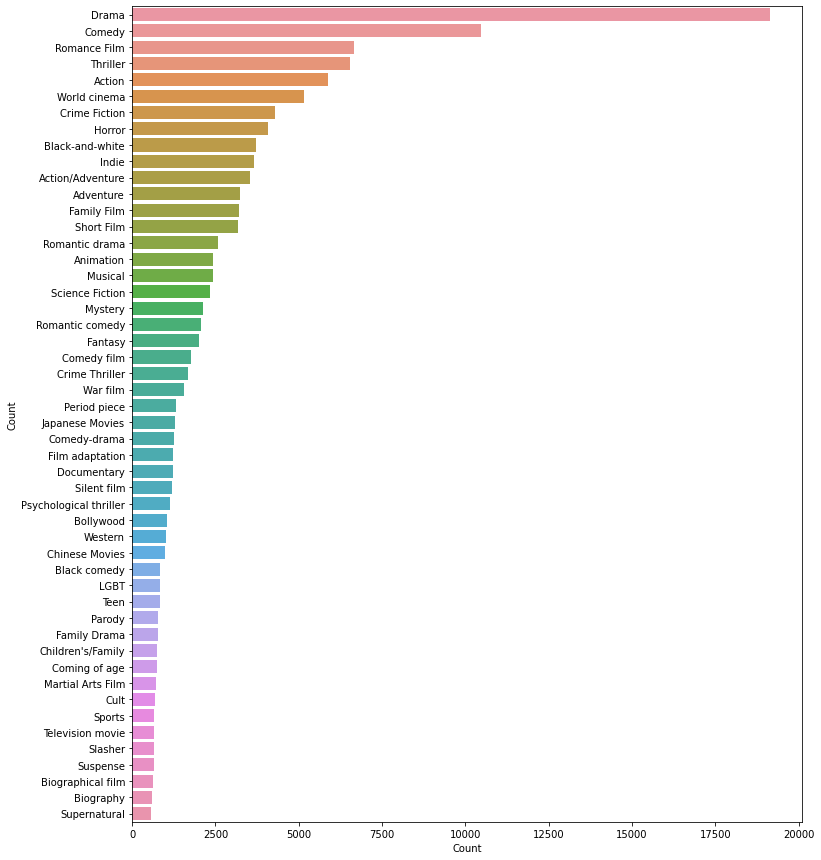

In [ ]:
#creating dictories of genre and occurrence accross the dataset
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

#plotting the distribution
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

# Consolidate Genre Labels

In [ ]:
import operator
sorted(count_dict.items(), key=operator.itemgetter(1))[::-1]

[('Drama', 19134),
 ('Comedy', 10467),
 ('Romance Film', 6666),
 ('Thriller', 6530),
 ('Action', 5868),
 ('World cinema', 5153),
 ('Crime Fiction', 4275),
 ('Horror', 4082),
 ('Black-and-white', 3731),
 ('Indie', 3668),
 ('Action/Adventure', 3553),
 ('Adventure', 3248),
 ('Family Film', 3219),
 ('Short Film', 3192),
 ('Romantic drama', 2572),
 ('Animation', 2441),
 ('Musical', 2414),
 ('Science Fiction', 2339),
 ('Mystery', 2119),
 ('Romantic comedy', 2075),
 ('Fantasy', 2012),
 ('Comedy film', 1778),
 ('Crime Thriller', 1682),
 ('War film', 1556),
 ('Period piece', 1321),
 ('Japanese Movies', 1290),
 ('Comedy-drama', 1261),
 ('Film adaptation', 1225),
 ('Documentary', 1213),
 ('Silent film', 1199),
 ('Psychological thriller', 1138),
 ('Bollywood', 1058),
 ('Western', 1022),
 ('Chinese Movies', 998),
 ('Black comedy', 834),
 ('LGBT', 825),
 ('Teen', 824),
 ('Parody', 767),
 ('Family Drama', 766),
 ("Children's/Family", 759),
 ('Coming of age', 741),
 ('Martial Arts Film', 706),
 ('Cult

In [ ]:
keep = ["Drama", "Comedy", "Romance Film", "Thriller", "Action", "Crime Fiction", "Horror", "Adventure", "Family Film", "Science Fiction"]
lst = list(all_genres.keys())
remove = [x for x in lst if x not in keep ]
len(remove)

353

In [ ]:
def remove_genres(genres):
    return [x for x in genres if x not in remove]

movies["list_genres_consol"] = movies["genres"].apply(lambda row: remove_genres(row))
len(movies)

41793

In [ ]:
movies.head(3)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",[Drama]
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]","[Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]","[Action, Drama]"


In [ ]:
movies = movies.explode("list_genres_consol")
movies = movies.reset_index(drop=True)
movies.head(2)
#movies.tail(10)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction


In [ ]:
movies = movies[movies.astype(str)["list_genres_consol"] != "[]"]
len(movies)

71571

In [ ]:
movies.head(3)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction
2,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Action


In [ ]:
#movies = movies.reset_index(drop=True)

26.73% of the movies are Drama
3.27% of the movies are Science Fiction
8.20% of the movies are Action
14.62% of the movies are Comedy
5.97% of the movies are Crime Fiction
9.12% of the movies are Thriller
5.70% of the movies are Horror
9.31% of the movies are Romance Film
4.50% of the movies are Family Film
4.54% of the movies are Adventure


[Text(0, 0, 'Drama'),
 Text(0, 0, 'Science Fiction'),
 Text(0, 0, 'Action'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Crime Fiction'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Romance Film'),
 Text(0, 0, 'Family Film'),
 Text(0, 0, 'Adventure')]

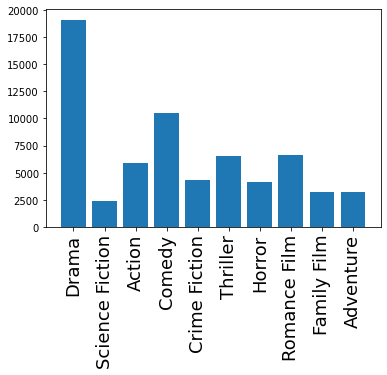

In [ ]:
for key in remove:
    if key in count_dict:
        del count_dict[key]

for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(movies), key))

fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)

In [ ]:
movies.head()

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction
2,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Action
3,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Drama
4,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]",Action


In [ ]:
#copying movies 
trail1= movies
trail1.head(2) 


,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction


In [ ]:
del trail1['movie_id']
del trail1['genres']

In [ ]:
trail1.columns = ["plots", "movie_name", "genres"]
trail1.head(4) 

,plots,movie_name,genres
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,Drama
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Science Fiction
2,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action
3,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Drama


In [ ]:
trail2 = trail1
trail2.head()

,plots,movie_name,genres
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,Drama
1,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,World cinema
2,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action/Adventure
3,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Science Fiction
4,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action
